<a href="https://colab.research.google.com/github/angelostefanini/data_analytics/blob/main/Test_clusterizzazione_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PIANIFICAZIONE - Si tratta di un notebook contenente un database di e-commerce che elenca gli acquisti effettuati da circa 4000 clienti nel corso di un anno (dal 01/12/2010 al 09/12/2011).

 L'obiettivo della nostra analisi è suddividere i clienti in segmenti distinti basandosi su caratteristiche e comportamenti simili, per poi indirizzare loro offerte e campagne marketing personalizzate. Uno sbocco possibile del lavoro potrebbe essere un recommendation system basato sulle preferenze dei clienti espresse dopo un certo numero di acquisti

Cercheremo quindi di rispondere sia in fase di analisi esplorativa che di clusterizzazione ad alcune domande di fondo per capire la struttura del dataset:
Chi sono i clienti dell’ecommerce?  ci sono dei pattern emergenti?
Che tipo di acquisti vengono effettuati?

Quali sono gli elementi che mi possono far capire il tipo di cliente?
Il paese di provenienza dell’utente svolge un ruolo?

Gli ordini cancellati che ruolo svolgono?

L’obiettivo del lavoro di clusterizzazione sarà creare dei cluster di prodotti sulla base dei quali raggruppare i clienti in diverse categorie di acquisto costituiti sul loro paniere di beni acquistati. Per fare questo implementeremo una clusterizzazione dei clienti basata sui dei pattern di acquisto ponderati e pesati in modo da definire 5-6 categorie di clienti secondo il metodo k-means.
Dopo aver formato le categorizzazioni dei clienti utilizzeremo il dataset degli acquisti per verificare in quale misura le x individuate riescono a predirre il cluster (Y)  assegnato al cliente prima in fase di clusterizzazione e poi in fase di training del modello.

Utilizzeremo diverse tecniche di ML supervisionato (logistic regression e SVC) e non supervisionato (kmeans, K-medoids, random forest) per individuare pattern di analisi emergenti dai dati.

In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

df=pd.read_csv("data.csv", encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

# Nuova sezione

In [11]:
df.shape

(541909, 8)

In [12]:
# Rimuovo le righe con valori nulli nella colonna 'CustomerID'
df = df.dropna(subset=['CustomerID'])

# Rimuovo le righe con valori nulli nella colonna 'Description'
df = df.dropna(subset=['Description'])

# rimuovo le righe duplicate
df = df.drop_duplicates()

# Lista dei valori da rimuovere
valori_da_rimuovere = ['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

# Rimuovi le righe con i valori specificati nella colonna 'StockCode'
df = df[~df['StockCode'].isin(valori_da_rimuovere)]

# Rimuovi gli ordini cancellati
df = df[~df['InvoiceNo'].str.startswith('C')]

In [13]:
df.shape

(391316, 8)

In [15]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom


Calcolo la percentuale di customerid per ogni paese all'interno dell'intero dataset

In [ ]:
# Eseguire il groupby per CustomerID e Country e contare le occorrenze
country_counts = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Count')

# Visualizzare il risultato
print(country_counts)


     CustomerID         Country  Count
0         12346  United Kingdom      1
1         12347         Iceland    182
2         12348         Finland     27
3         12349           Italy     72
4         12350          Norway     16
...         ...             ...    ...
4338      18280  United Kingdom     10
4339      18281  United Kingdom      7
4340      18282  United Kingdom     12
4341      18283  United Kingdom    719
4342      18287  United Kingdom     70

[4343 rows x 3 columns]


In [ ]:
# Eseguire il groupby per la colonna Country e contare il numero univoco di CustomerID
customer_per_country = country_counts.groupby('Country')['CustomerID'].count().reset_index(name='CustomerCount')

# Visualizzare il risultato
print(customer_per_country)


                 Country  CustomerCount
0              Australia              9
1                Austria             11
2                Bahrain              2
3                Belgium             25
4                 Brazil              1
5                 Canada              4
6        Channel Islands              9
7                 Cyprus              8
8         Czech Republic              1
9                Denmark              9
10                  EIRE              3
11    European Community              1
12               Finland             12
13                France             87
14               Germany             94
15                Greece              4
16               Iceland              1
17                Israel              3
18                 Italy             14
19                 Japan              8
20               Lebanon              1
21             Lithuania              1
22                 Malta              2
23           Netherlands              9


In [ ]:
# Calcolare il numero totale di CustomerID
total_customers = country_counts['CustomerID'].count()

# Eseguire il groupby per la colonna Country e calcolare la percentuale di CustomerID per ciascun paese
customer_per_country_percent = country_counts.groupby('Country')['CustomerID'].count() / total_customers * 100

# Visualizzare il risultato
print(customer_per_country_percent)


Country
Australia                0.207230
Austria                  0.253281
Bahrain                  0.046051
Belgium                  0.575639
Brazil                   0.023026
Canada                   0.092102
Channel Islands          0.207230
Cyprus                   0.184204
Czech Republic           0.023026
Denmark                  0.207230
EIRE                     0.069077
European Community       0.023026
Finland                  0.276307
France                   2.003224
Germany                  2.164402
Greece                   0.092102
Iceland                  0.023026
Israel                   0.069077
Italy                    0.322358
Japan                    0.184204
Lebanon                  0.023026
Lithuania                0.023026
Malta                    0.046051
Netherlands              0.207230
Norway                   0.230256
Poland                   0.138153
Portugal                 0.437486
RSA                      0.023026
Saudi Arabia             0.023026
Singap

Circa il 90% dei customer id sono britannici, dobbiamo valutare se aggiungere una variabile cosi' sbilanciata aggiunge informazioni alla nostra clusterizzazione dei clienti

In [ ]:
import nltk
nltk.download('stopwords')

import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df.shape

(391316, 8)

Verifico la distribuzione della variabile UnitPrice e la presenza di un numero eccessivo di outliers





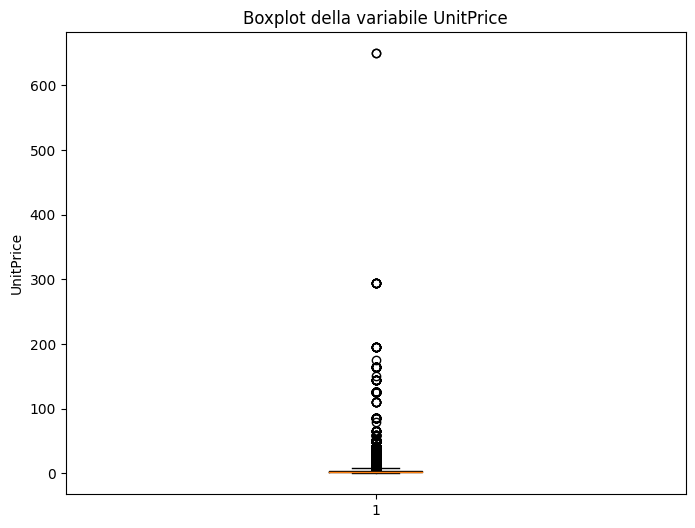

In [ ]:
import matplotlib.pyplot as plt

# Creazione del boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df['UnitPrice'])
plt.title('Boxplot della variabile UnitPrice')
plt.ylabel('UnitPrice')
plt.show()


In [ ]:
# Calcola il 95° percentile della variabile UnitPrice
percentile_95 = df['UnitPrice'].quantile(0.95)

# Identifica gli outlier al di sopra del 95° percentile
outliers = df[df['UnitPrice'] > percentile_95]

# Stampa il numero di outlier identificati
print("Numero di outlier al di sopra del 95° percentile:", len(outliers))


Numero di outlier al di sopra del 95° percentile: 15890


Applico la winsorization al 95 percentile della distribuzione di unitprice

In [ ]:
import pandas as pd

# Applica la scala logaritmica alla colonna 'UnitPrice'
df['UnitPrice_log_scaled'] = df['UnitPrice'].apply(lambda x: np.log(x + 1))  # Aggiungo 1 per evitare errori nel caso in cui ci siano zeri


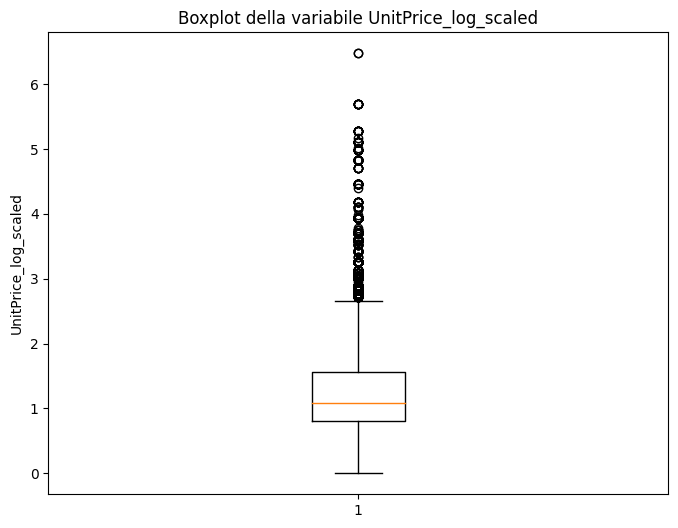

In [ ]:
import matplotlib.pyplot as plt

# Creazione del boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df['UnitPrice_log_scaled'])
plt.title('Boxplot della variabile UnitPrice_log_scaled')
plt.ylabel('UnitPrice_log_scaled')
plt.show()

Verifico il numero di clusterizzazioni con la migliore silhouette score tramite il modello Word2Vec, noto per considerare il significato delle parole. Word2Vec è un modello di rappresentazione del linguaggio naturale basato su reti neurali artificiali che impara a rappresentare le parole in uno spazio vettoriale continuo in modo che parole con significati simili siano collocate vicine tra loro nello spazio vettoriale. Questo significa che parole con significati simili avranno vettori simili. Utilizzando tecniche di apprendimento supervisionato o non supervisionato, il modello Word2Vec può essere addestrato su grandi corpora di testi per catturare le relazioni semantiche e sintattiche tra le parole. Pertanto, il modello Word2Vec è in grado di catturare il significato delle parole basandosi sul loro contesto di utilizzo nei testi.

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Riduco il DataFrame a 10.000 righe casuali
df_sample = df.sample(n=10000, random_state=42)

# Tokenizzazione e pulizia dei testi
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [ps.stem(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return cleaned_tokens

# Applico la tokenizzazione e la pulizia delle descrizioni
df_sample['CleanedDescription'] = df_sample['Description'].astype(str).apply(preprocess_text)

# Costruzione del modello Word2Vec
word2vec_model = Word2Vec(sentences=df_sample['CleanedDescription'], vector_size=100, window=5, min_count=1, sg=1)

# Costruzione dei vettori rappresentativi per le descrizioni
X_text = np.array([np.mean([word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv], axis=0) for tokens in df_sample['CleanedDescription']])

# Normalizzazione della variabile UnitPrice_log_scaled
scaler_price = StandardScaler()
X_price_normalized = scaler_price.fit_transform(df_sample[['UnitPrice_log_scaled']])

# Replico la matrice X_price_normalized per avere lo stesso numero di colonne di X_text
X_price_normalized_replicated = np.repeat(X_price_normalized, X_text.shape[1], axis=1)

# Combinazione delle features testuali e di UnitPrice
X_combined = np.concatenate((X_text, X_price_normalized_replicated), axis=1)

# Normalizzazione delle features
scaler_combined = StandardScaler()
X_combined_normalized = scaler_combined.fit_transform(X_combined)

# Applicazione della PCA
pca = PCA(n_components=2)
X_combined_pca = pca.fit_transform(X_combined_normalized)

# Calcolo del numero di campioni nel dataset
num_samples = X_combined_pca.shape[0]

# Sperimentazione con diversi numeri di cluster da 2 a 5
for num_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_combined_pca)

    # Calcolo del Silhouette Score
    silhouette_score_val = silhouette_score(X_combined_pca, clusters)

    # Calcolo dell'Inertia coefficient
    inertia_val = kmeans.inertia_ / num_samples

    print("Number of clusters:", num_clusters)
    print("Silhouette Score:", silhouette_score_val)
    print("Inertia coefficient:", inertia_val)
    print()






/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 2
Silhouette Score: 0.47050496407010717
Inertia coefficient: 58.73948306138122



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 3
Silhouette Score: 0.3511031793944845
Inertia coefficient: 43.080762650527305



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 4
Silhouette Score: 0.3892033516537588
Inertia coefficient: 31.041953320073



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 5
Silhouette Score: 0.3906071440432997
Inertia coefficient: 23.716671722556836



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


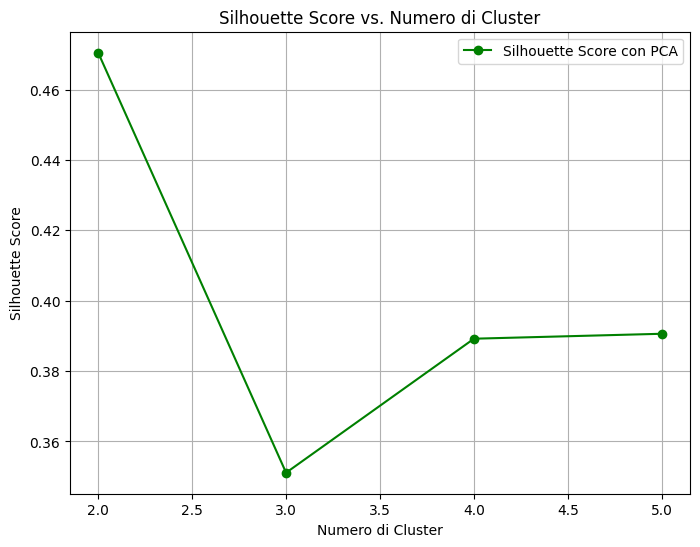

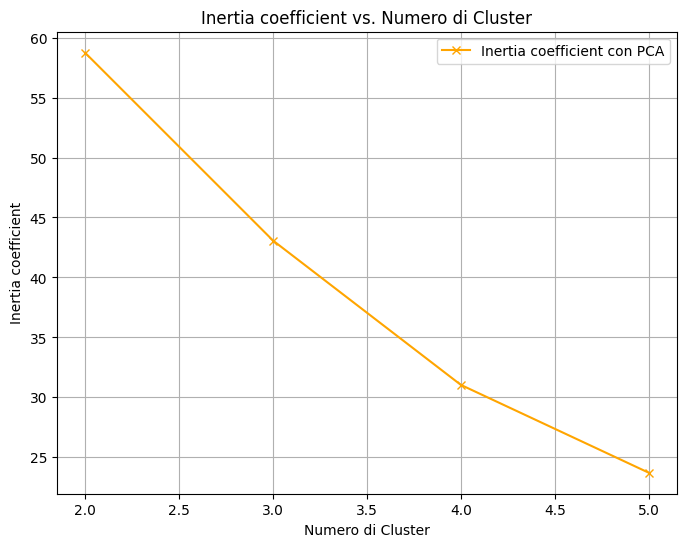

In [ ]:
# Applicazione della PCA
pca = PCA(n_components=2)
X_combined_pca = pca.fit_transform(X_combined_normalized)

# Calcolo del numero di campioni nel dataset
num_samples_pca = X_combined_pca.shape[0]

# Lista per memorizzare i risultati del Silhouette Score e dell'Inertia coefficient con PCA
silhouette_scores_pca = []
inertia_coefficients_pca = []

# Sperimentazione con diversi numeri di cluster da 2 a 5
for num_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_combined_pca)

    # Calcolo del Silhouette Score
    silhouette_score_val_pca = silhouette_score(X_combined_pca, clusters)

    # Calcolo dell'Inertia coefficient
    inertia_val_pca = kmeans.inertia_ / num_samples_pca

    silhouette_scores_pca.append(silhouette_score_val_pca)
    inertia_coefficients_pca.append(inertia_val_pca)

# Plot del Silhouette Score con e senza PCA
plt.figure(figsize=(8, 6))

plt.plot(range(2, 6), silhouette_scores_pca, label='Silhouette Score con PCA', marker='o', color='green')
plt.xlabel('Numero di Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Numero di Cluster')
plt.grid(True)
plt.legend()
plt.show()

# Plot dell'Inertia coefficient con e senza PCA
plt.figure(figsize=(8, 6))

plt.plot(range(2, 6), inertia_coefficients_pca, label='Inertia coefficient con PCA', marker='x', color='orange')
plt.xlabel('Numero di Cluster')
plt.ylabel('Inertia coefficient')
plt.title('Inertia coefficient vs. Numero di Cluster')
plt.grid(True)
plt.legend()
plt.show()




Plotto silhouette e inertia

In [ ]:
df.shape

(391316, 9)

Introduciamo il grafico varianza spiegata

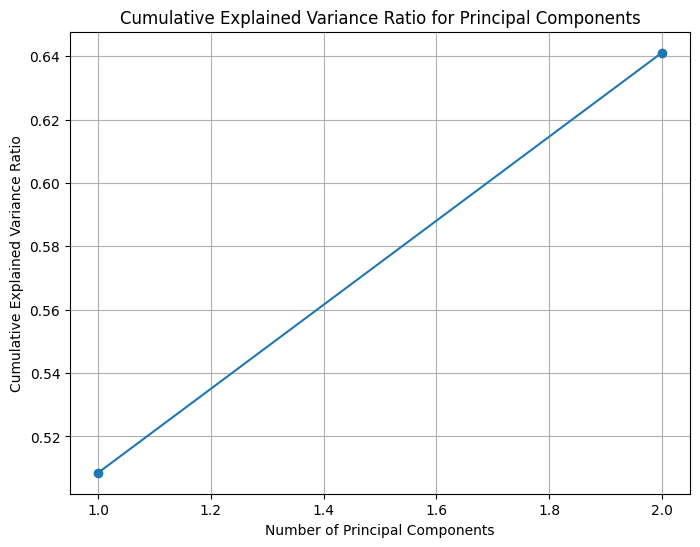

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalizzazione delle features
scaler_combined = StandardScaler()
X_combined_normalized = scaler_combined.fit_transform(X_combined)

# Calcolo della varianza spiegata
pca = PCA(n_components=2)  # Imposta il numero di componenti principali a 2
X_pca = pca.fit_transform(X_combined_normalized)
explained_variance_ratio = pca.explained_variance_ratio_

# Calcolo della varianza cumulata
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Grafico della varianza cumulata come linea retta spezzata
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for Principal Components')
plt.grid(True)
plt.show()



Eseguiamo la clusterizzazione secondo  il metodo word2vec su 5 cluster come da test precedente eseguito su 10.000 righe, prendiamo in considerazione le colonne della Description e UnitPrice in quanto elementi caratteristici principali di ogni articolo. Sulla colonna description abbiamo eseguito una tokenizzazione e una vettorializzazione delle keyword

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Tokenizzazione e pulizia dei testi
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [ps.stem(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return cleaned_tokens

# Applicazione della tokenizzazione e pulizia delle descrizioni
df['CleanedDescription'] = df['Description'].astype(str).apply(preprocess_text)

# Costruzione del modello Word2Vec
word2vec_model = Word2Vec(sentences=df['CleanedDescription'], vector_size=100, window=5, min_count=1, sg=1)

# Costruzione dei vettori rappresentativi per le descrizioni
X_text = np.array([np.mean([word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv], axis=0) for tokens in df['CleanedDescription']])

# Normalizzazione della variabile UnitPrice
scaler_price = StandardScaler()
X_price_normalized = scaler_price.fit_transform(df[['UnitPrice_log_scaled']])

# Replica la matrice X_price_normalized per avere lo stesso numero di colonne di X_text
X_price_normalized_replicated = np.repeat(X_price_normalized, X_text.shape[1], axis=1)

# Combinazione delle features testuali e di UnitPrice
X_combined = np.concatenate((X_text, X_price_normalized_replicated), axis=1)

# Normalizzazione delle features
scaler_combined = StandardScaler()
X_combined_normalized = scaler_combined.fit_transform(X_combined)

# Applicazione della PCA per ridurre la dimensionalità
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined_normalized)

# Esecuzione di KMeans con 5 cluster sui dati ridimensionati dalla PCA
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Calcolo del Silhouette Score
silhouette_score_val = silhouette_score(X_pca, clusters)

print("Number of clusters:", num_clusters)
print("Silhouette Score:", silhouette_score_val)
print()

# Aggiunta delle etichette dei cluster al DataFrame
df['Cluster'] = clusters

# Visualizzazione dei risultati
print(df.head())





/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 5
Silhouette Score: 0.424891229775241

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  UnitPrice_log_scaled  \
0  12/1/2010 8:26       2.55      17850  United Kingdom              1.266948   
1  12/1/2010 8:26       3.39      17850  United Kingdom              1.479329   
2  12/1/2010 8:26       2.75      17850  United Kingdom              1.321756   
3  12/1/2010 8:26       3.39      17850  United Kingdom              1.479329   
4  12/1/2010 8:26       3.39      17850  United Kingdom              1.479329   

                     

In [ ]:
df.shape

(391316, 11)

Risultato della clusterizzazione

In [ ]:
# Rimuovi la colonna 'CleanedDescription' dal DataFrame
df.drop('CleanedDescription', axis=1, inplace=True)


In [ ]:
# Conta quanti sono le transazioni per ogni cluster
cluster_counts = df['Cluster'].value_counts()

# Stampare il numero di transazioni per ogni cluster
print("Numero di transazioni per ogni cluster:")
print(cluster_counts)


Numero di transazioni per ogni cluster:
0    94082
3    89344
1    86259
4    73907
2    47724
Name: Cluster, dtype: int64


Creiamo la wordcloud secondo la clusterizzazione effettuata

In [ ]:


# Groupby a livello di "StockCode" e conteggio dei "StockCode" per ogni cluster
grouped = df.groupby(['StockCode', 'Cluster']).size().reset_index(name='Count')

# Groupby a livello di "Cluster" e conteggio degli "StockCode" per ogni cluster
cluster_counts = grouped.groupby('Cluster')['Count'].count().reset_index(name='StockCode_Count')

print("Numero di StockCode per ogni cluster:")
print(cluster_counts)


Numero di StockCode per ogni cluster:
   Cluster  StockCode_Count
0        0             1461
1        1             1259
2        2              799
3        3             1285
4        4              711


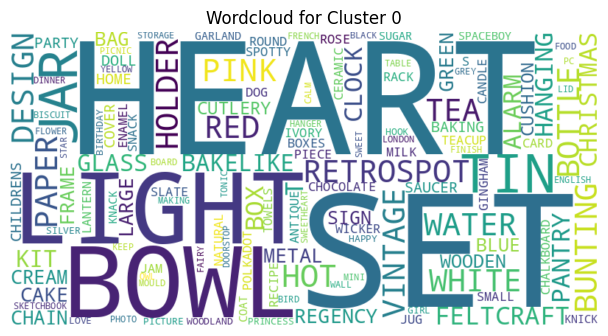

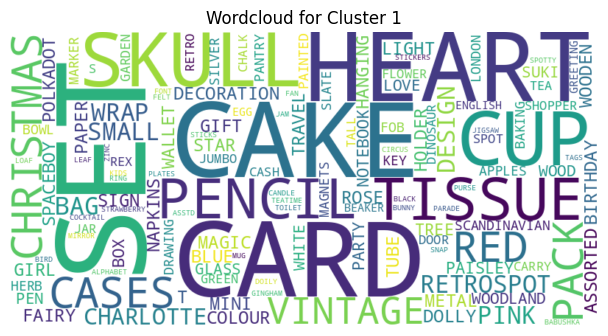

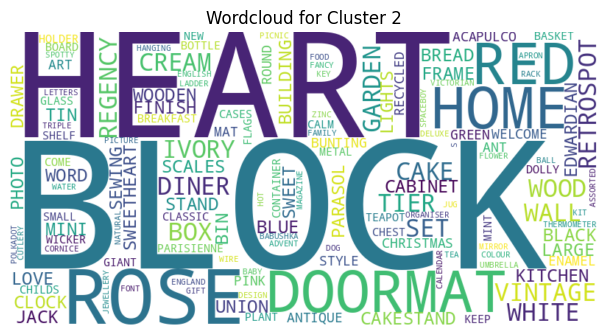

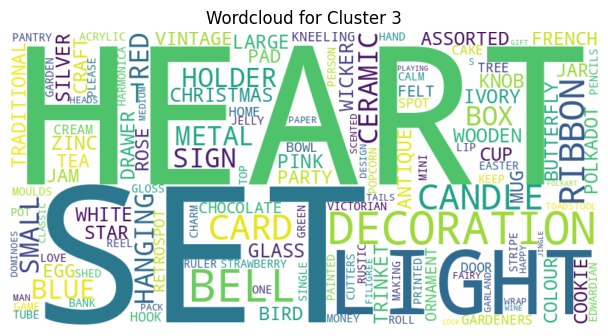

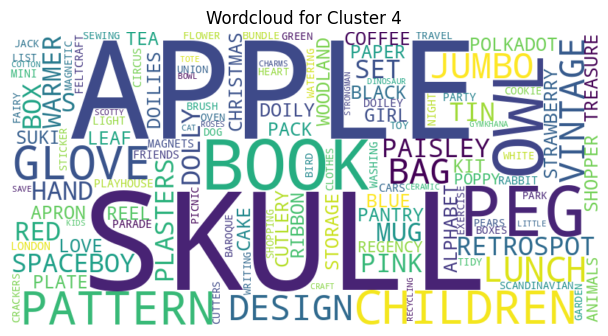

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Raggruppa il DataFrame per la colonna 'Cluster'
cluster_groups = df.groupby('Cluster')

# Definisci una funzione per ottenere le parole più frequenti all'interno di un cluster
def get_top_words(cluster_description):
    # Concatena tutte le descrizioni dei prodotti all'interno del cluster
    all_descriptions = ' '.join(cluster_description.astype(str))
    # Tokenizzazione delle parole e pulizia dei testi (se necessario)
    tokens = word_tokenize(all_descriptions)
    # Calcola la frequenza delle parole
    word_freq = Counter(tokens)
    # Ritorna le prime 50 parole più frequenti
    return word_freq.most_common(150)

# Crea le wordclouds per ogni cluster
for cluster, cluster_data in cluster_groups:
    # Ottieni le parole più frequenti all'interno del cluster
    top_words = get_top_words(cluster_data['Description'])
    # Crea una stringa con le parole e le relative frequenze per la wordcloud
    wordcloud_text = ' '.join([word for word, freq in top_words])
    # Crea la wordcloud
    plt.figure(figsize=(8, 4))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud for Cluster {cluster}')
    plt.axis('off')
    plt.tight_layout(pad=3)  # Aggiungi spazio tra le wordclouds
    plt.show()




Il risultato della clusterizzazione in questa fase non sembra essere ottimale ma confidiamo che possa migliorare aumentando le dimensioni del campione, delle keyword e del dataset

Plotto la clusterizzazione dei clienti sulla base degli articoli acquistati nei 5 cluster risultato dell'algoritmo


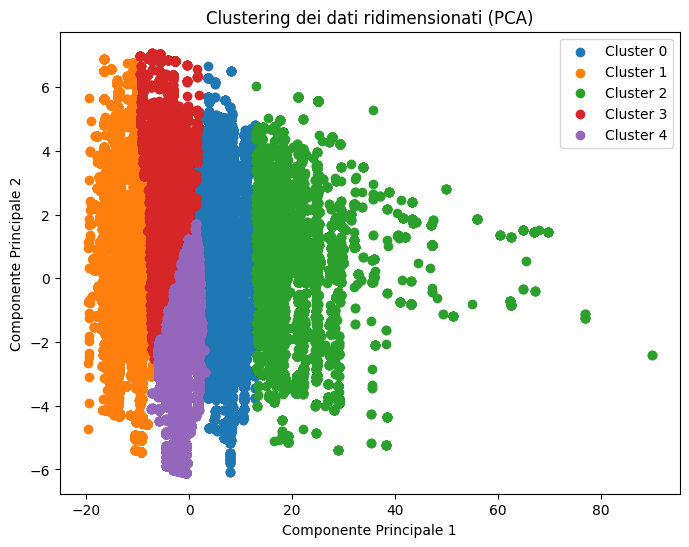

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Riduzione della dimensionalità con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined_normalized)

# Plot dei cluster
plt.figure(figsize=(8, 6))
for cluster_label in range(num_clusters):
    cluster_data = X_pca[df['Cluster'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')

plt.title('Clustering dei dati ridimensionati (PCA)')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend()
plt.show()


In [ ]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,UnitPrice_log_scaled,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,1.266948,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,1.479329,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,1.321756,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,1.479329,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,1.479329,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,2.157559,2
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,1.658228,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,1.047319,4
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,1.047319,4
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom,0.989541,3


In [ ]:
# Elimina la colonna 'UnitPrice_log_scaled' dal DataFrame
df.drop('UnitPrice_log_scaled', axis=1, inplace=True)

# Visualizza il DataFrame aggiornato
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice CustomerID         Country  Cluster  
0 

Aggiungo total price per ogni transazione/ordine

In [ ]:
# Calcolo la colonna TotalPrice come prodotto di Quantity e UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Visualizzo il DataFrame con la nuova colonna TotalPrice
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  Cluster  TotalPrice  
0  12/1/2010 8:26       2.55      17850  United Kingdom        0       15.30  
1  12/1/2010 8:26       3.39      17850  United Kingdom        0       20.34  
2  12/1/2010 8:26       2.75      17850  United Kingdom        0       22.00  
3  12/1/2010 8:26       3.39      17850  United Kingdom        0       20.34  
4  12/1/2010 8:26       3.39      17850  United Kingdom        0       20.34  


In [ ]:
import pandas as pd

# Codifica la variabile 'Country' come dummy
df['UK'] = df['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)
df['Resto_del_mondo'] = df['Country'].apply(lambda x: 1 if x != 'United Kingdom' else 0)

# Rimuovi la colonna 'Country' originale
df.drop(columns=['Country'], inplace=True)

# Visualizzo il DataFrame con la nuova colonna TotalPrice
print(df.head())



  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID  Cluster  TotalPrice  UK  \
0  12/1/2010 8:26       2.55      17850        0       15.30   1   
1  12/1/2010 8:26       3.39      17850        0       20.34   1   
2  12/1/2010 8:26       2.75      17850        0       22.00   1   
3  12/1/2010 8:26       3.39      17850        0       20.34   1   
4  12/1/2010 8:26       3.39      17850        0       20.34   1   

   Resto_del_mondo  
0                0  
1                0  
2                0  
3                0  
4                0  


Aggiungo totalprice e lo categorizzo secondo il cluster di appartenenza

In [ ]:
# Inizializzo le colonne cluster_0, cluster_1, cluster_2, cluster_3, cluster_4 con valori 0
df['cluster_0'] = 0
df['cluster_1'] = 0
df['cluster_2'] = 0
df['cluster_3'] = 0
df['cluster_4'] = 0

# Copio i valori dalla colonna TotalPrice alle colonne cluster_0, cluster_1, cluster_2, cluster_3, cluster_4 in base al valore di Cluster
for i in range(5):  # Supponendo che ci siano 5 cluster
    mask = df['Cluster'] == i
    df.loc[mask, f'cluster_{i}'] = df.loc[mask, 'TotalPrice']

# Visualizzo il DataFrame con le nuove colonne aggiunte
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID  Cluster  TotalPrice  UK  \
0  12/1/2010 8:26       2.55      17850        0       15.30   1   
1  12/1/2010 8:26       3.39      17850        0       20.34   1   
2  12/1/2010 8:26       2.75      17850        0       22.00   1   
3  12/1/2010 8:26       3.39      17850        0       20.34   1   
4  12/1/2010 8:26       3.39      17850        0       20.34   1   

   Resto_del_mondo  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  
0                0      15.30        0.0        0.0        0.0        0.0  
1     

In [ ]:
import pandas as pd

# Converti la colonna 'InvoiceDate' nel formato datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Raggruppa i dati per 'CustomerID'
grouped = df.groupby('CustomerID')

# Calcola la differenza fra la data massima e la data minima per ogni gruppo
customer_days = grouped['InvoiceDate'].max() - grouped['InvoiceDate'].min()

# Calcola i giorni totali come numeri interi
customer_days_numeric = customer_days.dt.days

# Aggiungi la colonna 'CustomerDaysNumeric' al DataFrame originale
df['days_between_purchases'] = df['CustomerID'].map(customer_days_numeric)

# Trova la data della prima fattura emessa per ogni customer ID e il mese corrispondente
first_invoice_month = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.month

# Aggiungi la colonna 'FirstInvoiceMonth' al DataFrame originale
df['FirstInvoiceMonth'] = first_invoice_month

# Visualizza il DataFrame con la nuova colonna
print(df)



       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID  Cluster  TotalPrice  UK  

Creo una tabella pivot

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Cluster', 'TotalPrice', 'UK',
       'Resto_del_mondo', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4', 'days_between_purchases', 'FirstInvoiceMonth'],
      dtype='object')

In [ ]:
# Creo la tabella pivot includendo "days between purchases" nell'indice
pivot_table = df.pivot_table(index=['CustomerID', 'InvoiceNo', 'InvoiceDate', 'days_between_purchases', 'FirstInvoiceMonth'],
                             values=['TotalPrice', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'UK', 'Resto_del_mondo'],
                             aggfunc={'TotalPrice': 'sum', 'cluster_0': 'sum', 'cluster_1': 'sum', 'cluster_2': 'sum',
                                       'cluster_3': 'sum', 'cluster_4': 'sum', 'UK': 'min', 'Resto_del_mondo': 'min'})

# Reset dell'indice
pivot_table.reset_index(inplace=True)


# Visualizzare la tabella pivot
print(pivot_table.head(10))







  CustomerID InvoiceNo         InvoiceDate  days_between_purchases  \
0      12346    541431 2011-01-18 10:01:00                       0   
1      12347    537626 2010-12-07 14:57:00                     365   
2      12347    542237 2011-01-26 14:30:00                     365   
3      12347    549222 2011-04-07 10:43:00                     365   
4      12347    556201 2011-06-09 13:01:00                     365   
5      12347    562032 2011-08-02 08:48:00                     365   
6      12347    573511 2011-10-31 12:25:00                     365   
7      12347    581180 2011-12-07 15:52:00                     365   
8      12348    539318 2010-12-16 19:09:00                     282   
9      12348    541998 2011-01-25 10:42:00                     282   

   FirstInvoiceMonth  Resto_del_mondo  TotalPrice  UK  cluster_0  cluster_1  \
0                  1                0    77183.60   1       0.00       0.00   
1                 12                1      711.79   0     415.39      2

Raggruppo per customer id

In [ ]:
# Raggruppo le fatture per CustomerID e Country, e calcolo le statistiche richieste
customer_stats = pivot_table.groupby(['CustomerID', 'days_between_purchases']).agg({
    'TotalPrice': ['count', 'min', 'max', 'mean', 'sum'],
    'cluster_0': 'sum',
    'cluster_1': 'sum',
    'cluster_2': 'sum',
    'cluster_3': 'sum',
    'cluster_4': 'sum',
    'FirstInvoiceMonth': 'min',
    'UK': 'min',
    'Resto_del_mondo': 'min'
    # Aggiunta del cluster_4
})

# Visualizzare le statistiche per i clienti
print(customer_stats.head(20))


                                  TotalPrice                      \
                                       count       min       max   
CustomerID days_between_purchases                                  
12346      0                               1  77183.60  77183.60   
12347      365                             7    224.82   1294.32   
12348      282                             4    187.44    652.80   
12349      0                               1   1457.55   1457.55   
12350      0                               1    294.40    294.40   
12352      260                             7    104.35    296.50   
12353      0                               1     89.00     89.00   
12354      0                               1   1079.40   1079.40   
12355      0                               1    459.40    459.40   
12356      302                             3     58.35   1947.62   
12357      0                               1   6207.67   6207.67   
12358      149                             2    

In [ ]:
print(customer_stats.columns)

MultiIndex([(       'TotalPrice', 'count'),
            (       'TotalPrice',   'min'),
            (       'TotalPrice',   'max'),
            (       'TotalPrice',  'mean'),
            (       'TotalPrice',   'sum'),
            (        'cluster_0',   'sum'),
            (        'cluster_1',   'sum'),
            (        'cluster_2',   'sum'),
            (        'cluster_3',   'sum'),
            (        'cluster_4',   'sum'),
            ('FirstInvoiceMonth',   'min'),
            (               'UK',   'min'),
            (  'Resto_del_mondo',   'min')],
           )


Aggiungo la metrica del numero di giorni fra prima e ultima fattura per vedere quanti giorni un cliente è stato cliente, piu' è alto il numero piu' lungo è stato il ciclo degli acquisti

In [ ]:
# Calcola il valore medio delle transazioni per ogni cliente
customer_stats['AvgTransactionValue'] = customer_stats['TotalPrice']['sum'] / customer_stats['TotalPrice']['count']


# Calcola la durata della relazione per ogni cliente
customer_stats['RelationshipDuration'] = customer_stats.index.get_level_values('days_between_purchases')

customer_stats['RelationshipDuration'] = customer_stats['RelationshipDuration'].clip(lower=1)







In [ ]:
#  Rimuovo la colonna avg transaction value perchè è una ripetizione di mean


customer_stats = customer_stats.drop(columns=['AvgTransactionValue'])

In [ ]:
customer_stats.head(10)

TotalPrice                      \
                                       count       min       max   
CustomerID days_between_purchases                                  
12346      0                               1  77183.60  77183.60   
12347      365                             7    224.82   1294.32   
12348      282                             4    187.44    652.80   
12349      0                               1   1457.55   1457.55   
12350      0                               1    294.40    294.40   
12352      260                             7    104.35    296.50   
12353      0                               1     89.00     89.00   
12354      0                               1   1079.40   1079.40   
12355      0                               1    459.40    459.40   
12356      302                             3     58.35   1947.62   

                                                          cluster_0 cluster_1  \
                                           mean       sum       sum       sum   
CustomerID days_between_purchases                                               
12346      0                       77183.600000  77183.60      0.00      0.00   
12347      365                       615.714286   4310.00   1890.83    545.52   
12348      282                       359.310000   1437.24      0.00    683.24   
12349      0                        1457.550000   1457.55    384.14     88.80   
12350      0                         294.400000    294.40     17.70     39.10   
12352      260                       197.962857   1385.74    481.30     31.00   
12353      0                          89.000000     89.00     17.70      0.00   
12354      0                        1079.400000   1079.40    280.50    161.38   
12355      0                         459.400000    459.40    169.20      0.00   
12356      302                       829.143333   2487.43    476.30    403.27   

                                  cluster_2 cluster_3 cluster_4  \
                                        sum       sum       sum   
CustomerID days_between_purchases                                 
12346      0                           0.00  77183.60      0.00   
12347      365                       400.25   1019.60    453.80   
12348      282                         0.00    649.60    104.40   
12349      0                         449.45    266.72    268.44   
12350      0                           0.00    147.60     90.00   
12352      260                       399.40    332.80    141.24   
12353      0                          59.70     11.60      0.00   
12354      0                         252.00     84.60    300.92   
12355      0                          45.40    244.80      0.00   
12356      302                       742.83    701.87    163.16   

                                  FirstInvoiceMonth  UK Resto_del_mondo  \
                                                min min             min   
CustomerID days_between_purchases                                         
12346      0                                      1   1               0   
12347      365                                   12   0               1   
12348      282                                   12   0               1   
12349      0                                     11   0               1   
12350      0                                      2   0               1   
12352      260                                    2   0               1   
12353      0                                      5   0               1   
12354      0                                      4   0               1   
12355      0                                      5   0               1   
12356      302                                    1   0               1   

                                  RelationshipDuration  
                                                        
CustomerID days_between_purchases                       
12346      0                                         1  
12347      365     

In [ ]:


# Visualizza la tabella
print(customer_stats.head())

                                  TotalPrice                      \
                                       count       min       max   
CustomerID days_between_purchases                                  
12346      0                               1  77183.60  77183.60   
12347      365                             7    224.82   1294.32   
12348      282                             4    187.44    652.80   
12349      0                               1   1457.55   1457.55   
12350      0                               1    294.40    294.40   

                                                          cluster_0 cluster_1  \
                                           mean       sum       sum       sum   
CustomerID days_between_purchases                                               
12346      0                       77183.600000  77183.60      0.00      0.00   
12347      365                       615.714286   4310.00   1890.83    545.52   
12348      282                       359.310000   

In [ ]:
# Rimuovi la colonna "days_between_purchases" dal DataFrame
pivot_table = pivot_table.drop(columns=['days_between_purchases'])


# Visualizza la tabella aggiornata
print(customer_stats.head())

                                  TotalPrice                      \
                                       count       min       max   
CustomerID days_between_purchases                                  
12346      0                               1  77183.60  77183.60   
12347      365                             7    224.82   1294.32   
12348      282                             4    187.44    652.80   
12349      0                               1   1457.55   1457.55   
12350      0                               1    294.40    294.40   

                                                          cluster_0 cluster_1  \
                                           mean       sum       sum       sum   
CustomerID days_between_purchases                                               
12346      0                       77183.600000  77183.60      0.00      0.00   
12347      365                       615.714286   4310.00   1890.83    545.52   
12348      282                       359.310000   

In [ ]:
print(customer_stats.columns)

MultiIndex([(          'TotalPrice', 'count'),
            (          'TotalPrice',   'min'),
            (          'TotalPrice',   'max'),
            (          'TotalPrice',  'mean'),
            (          'TotalPrice',   'sum'),
            (           'cluster_0',   'sum'),
            (           'cluster_1',   'sum'),
            (           'cluster_2',   'sum'),
            (           'cluster_3',   'sum'),
            (           'cluster_4',   'sum'),
            (   'FirstInvoiceMonth',   'min'),
            (                  'UK',   'min'),
            (     'Resto_del_mondo',   'min'),
            ('RelationshipDuration',      '')],
           )


Calcolo il numero di clienti con un solo acquisto

In [ ]:
# Conto il numero di clienti con un solo acquisto
one_time_customers = customer_stats[('TotalPrice', 'count')].eq(1).sum()

print("Numero di clienti con un solo acquisto:", one_time_customers)




Numero di clienti con un solo acquisto: 1504


In [ ]:
# Calcola il numero totale di clienti
total_customers = len(customer_stats)

# Calcola il numero di clienti con un solo acquisto
one_time_customers = customer_stats[('TotalPrice', 'count')].eq(1).sum()

# Calcola la percentuale di clienti con un solo acquisto
percentage_one_time_customers = (one_time_customers / total_customers) * 100

print("Percentuale di clienti con un solo acquisto:", percentage_one_time_customers)


Percentuale di clienti con un solo acquisto: 34.694348327566324


In [ ]:
# Calcola il numero di clienti con un determinato numero di acquisti
purchase_counts = customer_stats[('TotalPrice', 'count')]

# Calcola la distribuzione degli acquisti fra i clienti
purchase_distribution = purchase_counts.value_counts().sort_index()

# Stampa la distribuzione degli acquisti
print("Distribuzione degli acquisti fra i clienti:")
print(purchase_distribution)


Distribuzione degli acquisti fra i clienti:
1      1504
2       832
3       500
4       394
5       239
6       173
7       138
8        95
9        73
10       53
11       56
12       43
13       29
14       19
15       26
16       10
17       19
18       13
19       12
20       13
21        9
22        7
23        4
24        3
25        8
26        7
27        4
28        5
29        2
30        3
31        3
32        3
33        2
34        4
36        1
37        3
38        1
39        2
41        1
44        2
46        1
47        2
48        1
50        1
51        1
55        2
57        1
60        1
62        2
73        1
86        1
91        1
92        1
97        1
124       1
200       1
207       1
Name: (TotalPrice, count), dtype: int64


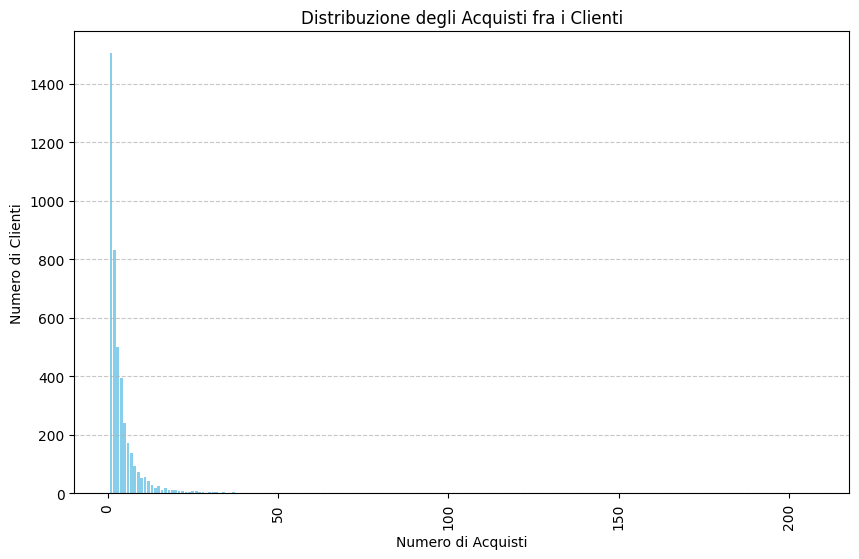

In [ ]:
import matplotlib.pyplot as plt

# Distribuzione degli acquisti fra i clienti
purchase_distribution = {
    1: 1504, 2: 832, 3: 500, 4: 394, 5: 239, 6: 173, 7: 138, 8: 95, 9: 73, 10: 53,
    11: 56, 12: 43, 13: 29, 14: 19, 15: 26, 16: 10, 17: 19, 18: 13, 19: 12, 20: 13,
    21: 9, 22: 7, 23: 4, 24: 3, 25: 8, 26: 7, 27: 4, 28: 5, 29: 2, 30: 3, 31: 3,
    32: 3, 33: 2, 34: 4, 36: 1, 37: 3, 38: 1, 39: 2, 41: 1, 44: 2, 46: 1, 47: 2,
    48: 1, 50: 1, 51: 1, 55: 2, 57: 1, 60: 1, 62: 2, 73: 1, 86: 1, 91: 1, 92: 1,
    97: 1, 124: 1, 200: 1, 207: 1
}

# Estrai i valori e le etichette
values = list(purchase_distribution.values())
labels = list(purchase_distribution.keys())

# Plotta il grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Numero di Acquisti')
plt.ylabel('Numero di Clienti')
plt.title('Distribuzione degli Acquisti fra i Clienti')
plt.xticks(rotation=90)  # Ruota le etichette sull'asse x per una migliore leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Aggiungi una griglia solo sull'asse y
plt.show()


Plotto la distribuzione della variabile somma delle fatture

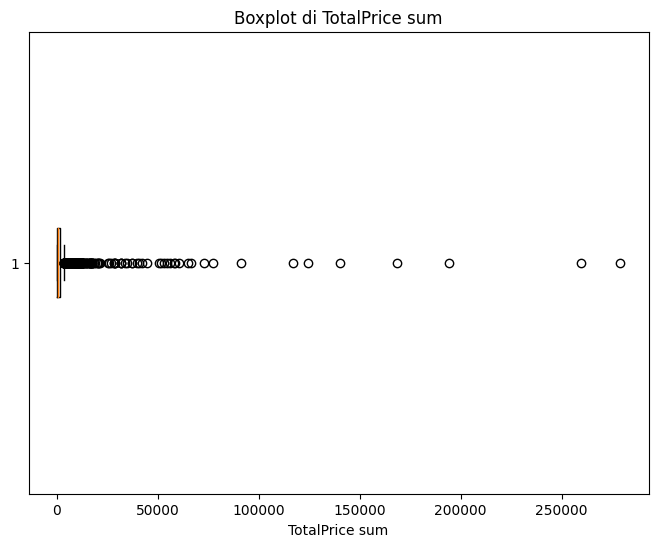

In [ ]:
import matplotlib.pyplot as plt

# Seleziona la colonna 'TotalPrice', 'sum'
total_price_sum = customer_stats[('TotalPrice', 'sum')]

# Crea il boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(total_price_sum, vert=False)
plt.title('Boxplot di TotalPrice sum')
plt.xlabel('TotalPrice sum')
plt.show()


Ci sono evidentemente degli outliers e dei clienti che potrebbero rendere non ottimale la classificazione, dobbiamo verificare a monte se riusciamo ad eliminare le transazioni estreme

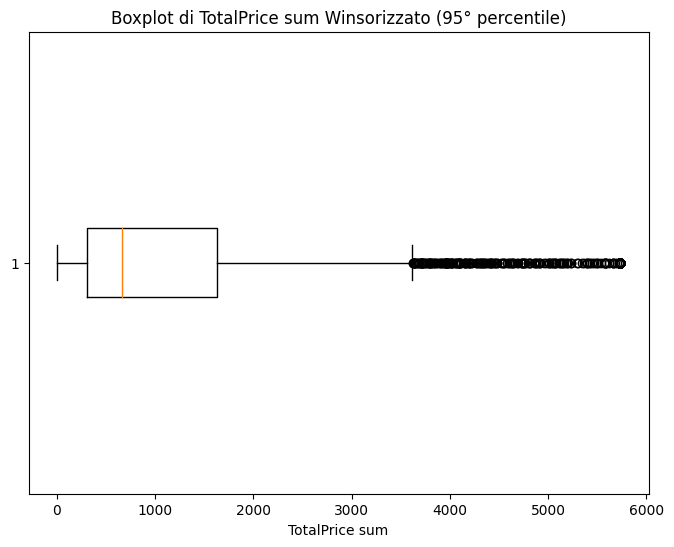

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calcola il 95° percentile
percentile = 95

# Calcola il valore al 95° percentile
percentile_value = np.percentile(customer_stats[('TotalPrice', 'sum')], percentile)

# Applica la winsorizzazione
customer_stats[('TotalPrice', 'sum')] = np.where(customer_stats[('TotalPrice', 'sum')] > percentile_value,
                                                  percentile_value,
                                                  customer_stats[('TotalPrice', 'sum')])

# Plotta il boxplot dei dati winsorizzati
plt.figure(figsize=(8, 6))
plt.boxplot(customer_stats[('TotalPrice', 'sum')], vert=False)
plt.title('Boxplot di TotalPrice sum Winsorizzato (95° percentile)')
plt.xlabel('TotalPrice sum')
plt.show()





In [ ]:
customer_stats.columns

MultiIndex([(          'TotalPrice', 'count'),
            (          'TotalPrice',   'min'),
            (          'TotalPrice',   'max'),
            (          'TotalPrice',  'mean'),
            (          'TotalPrice',   'sum'),
            (           'cluster_0',   'sum'),
            (           'cluster_1',   'sum'),
            (           'cluster_2',   'sum'),
            (           'cluster_3',   'sum'),
            (           'cluster_4',   'sum'),
            (   'FirstInvoiceMonth',   'min'),
            (                  'UK',   'min'),
            (     'Resto_del_mondo',   'min'),
            ('RelationshipDuration',      '')],
           )

In [ ]:
from sklearn.preprocessing import StandardScaler

# Seleziona solo le colonne numeriche
numeric_cols = customer_stats.select_dtypes(include=[np.number])

# Istanzia l'oggetto StandardScaler
scaler = StandardScaler()

# Applica la standardizzazione ai dati numerici
scaled_data = scaler.fit_transform(numeric_cols)

# Costruisci un nuovo DataFrame con i dati standardizzati
scaled_customer_stats = pd.DataFrame(data=scaled_data, index=numeric_cols.index, columns=numeric_cols.columns)

# Stampare il DataFrame standardizzato
print(scaled_customer_stats)








                                  TotalPrice                                   \
                                       count        min        max       mean   
CustomerID days_between_purchases                                               
12346      0                       -0.424435  62.882256  24.791310  42.640231   
12347      365                      0.358345  -0.031795   0.209917   0.111428   
12348      282                     -0.033045  -0.062353   0.002122  -0.030989   
12349      0                       -0.424435   0.975966   0.262789   0.579016   
12350      0                       -0.424435   0.025087  -0.113968  -0.067043   
...                                      ...        ...        ...        ...   
18280      0                       -0.424435  -0.067945  -0.150829  -0.130252   
18281      0                       -0.424435  -0.149515  -0.183149  -0.185674   
18282      118                     -0.293972  -0.151951  -0.176868  -0.181116   
18283      333              

Effettuo la PCA per individuare la % di varianza cumulata spiegata da ogni variabile

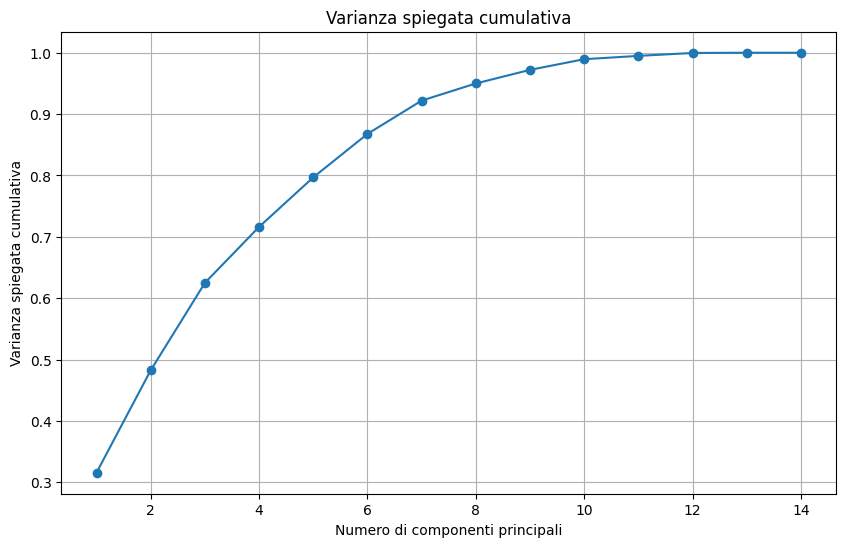

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Inizializza il modello PCA
pca = PCA()

# Adatta il modello ai dati
pca.fit(scaled_customer_stats)

# Ottieni la percentuale di varianza spiegata da ciascuna componente principale
explained_variance_ratio = pca.explained_variance_ratio_

# Calcola la varianza cumulativa spiegata
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

# Plot della varianza spiegata cumulativa
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.title('Varianza spiegata cumulativa')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.grid(True)
plt.show()


Come da grafico decido di effettuare la pca solo su 10 variabili in base alla varianza spiegata

In [ ]:
from sklearn.decomposition import PCA

# Inizializza il modello PCA con 10 componenti principali
pca = PCA(n_components=11)

# Adatta il modello ai dati
pca.fit(scaled_customer_stats)

# Trasforma i dati utilizzando il modello PCA
data_transformed = pca.transform(scaled_customer_stats)


Effettuo la PCA

In [ ]:
import pandas as pd

# Nomi delle colonne per il nuovo DataFrame
column_names = [f'PC{i}' for i in range(1, 12)]  # Sostituisci 8 con il numero effettivo di componenti principali

# Crea un DataFrame utilizzando i dati trasformati
pca_df = pd.DataFrame(data_transformed, columns=column_names, index=scaled_customer_stats.index)

# Stampare le prime righe del nuovo DataFrame
print(pca_df.head())


                                         PC1        PC2       PC3       PC4  \
CustomerID days_between_purchases                                             
12346      0                       44.304917  61.118641  8.982494 -0.787247   
12347      365                      1.884200  -0.805661 -4.226843 -1.576491   
12348      282                      0.642899  -0.142313 -4.228775 -0.594150   
12349      0                        0.379331   1.495767 -4.185273  0.565172   
12350      0                       -0.545715   1.015547 -4.366697  0.633157   

                                         PC5       PC6        PC7       PC8  \
CustomerID days_between_purchases                                             
12346      0                       43.564373 -6.517532  11.910252 -1.210036   
12347      365                      0.508501 -1.447094  -0.668317 -0.714567   
12348      282                      0.013019 -1.413601  -0.047380 -0.954162   
12349      0                        0.301755 -1.305

Verifico qual è il numero di cluster da creare

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

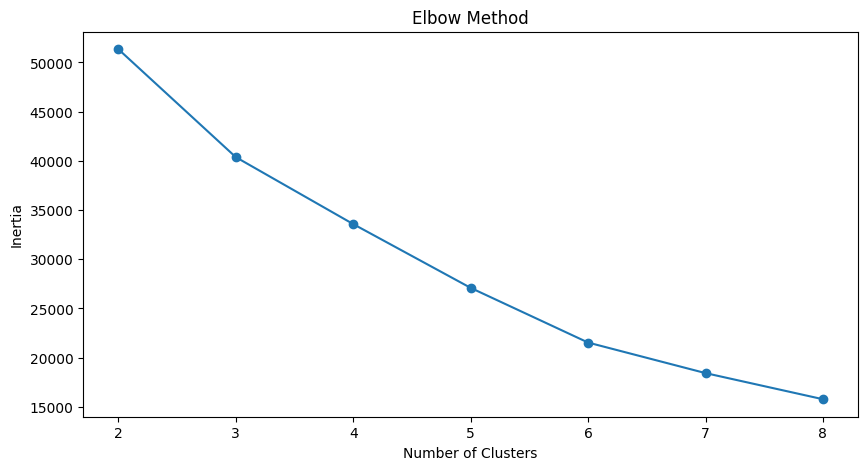

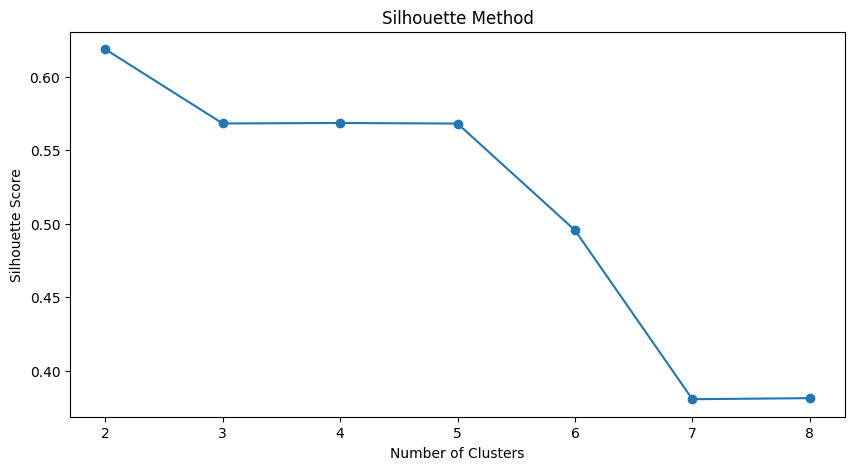

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Definisci il range dei possibili numeri di cluster
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Calcola l'inertia e la silhouette per ogni numero di cluster
inertia_values = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_transformed)

    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_transformed, cluster_labels))

# Plot dell'elbow (gomito) per trovare il numero ottimale di cluster
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Plot della silhouette per trovare il numero ottimale di cluster
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()


Elbow Method (Metodo dell'Elbow): Questo metodo valuta la variazione della somma dei quadrati delle distanze (inertia) al variare del numero di cluster. Cerca il punto in cui la curva inizia a piegarsi, formando un "gomito". Questo punto può indicare un cambiamento nella variazione dei dati e quindi il numero ottimale di cluster. Tuttavia, può essere influenzato dalla forma dei dati e potrebbe non essere sempre chiaro dove esattamente si trova il "gomito".

Silhouette Method (Metodo della Silhouette): Questo metodo calcola la silhouette media di ogni campione, che misura quanto un campione è simile al suo cluster rispetto agli altri cluster. Un valore più alto della silhouette media indica che i campioni sono stati assegnati a cluster appropriati. Questo metodo fornisce una misura più diretta della coesione dei cluster e può essere più affidabile in certi contesti.

[testo del link](https://)Opto per la creazione di 8
 cluster di clienti come da incrocio fra Silhouette e Inertia

Effettuo la clusterizzazione impostando 7 cluster

In [ ]:
from sklearn.cluster import KMeans

# Numero di cluster desiderato
n_clusters = 6

# Inizializza il modello KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Adatta il modello ai dati trasformati dopo la PCA
kmeans.fit(data_transformed)

# Aggiungi le etichette dei cluster al DataFrame
cluster_labels = kmeans.labels_
scaled_customer_stats['Cluster'] = cluster_labels

# Visualizza i risultati della clusterizzazione
print(scaled_customer_stats.head())

# Calcola la silhouette score
silhouette_avg = silhouette_score(data_transformed, cluster_labels)

# Stampa la silhouette score
print("Silhouette Score:", silhouette_avg)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                  TotalPrice                                   \
                                       count        min        max       mean   
CustomerID days_between_purchases                                               
12346      0                       -0.424435  62.882256  24.791310  42.640231   
12347      365                      0.358345  -0.031795   0.209917   0.111428   
12348      282                     -0.033045  -0.062353   0.002122  -0.030989   
12349      0                       -0.424435   0.975966   0.262789   0.579016   
12350      0                       -0.424435   0.025087  -0.113968  -0.067043   

                                            cluster_0 cluster_1 cluster_2  \
                                        sum       sum       sum       sum   
CustomerID days_between_purchases                                           
12346      0                       2.969868 -0.174206 -0.228725 -0.195802   
12347      365                     2.018563

Conto il numero di clienti per cluster

In [ ]:
# Conto il numero di clienti in ogni cluster
cluster_counts = scaled_customer_stats['Cluster'].value_counts()

# Visualizza il numero di clienti in ogni cluster
print(cluster_counts)


0    3249
2     665
1     413
4       6
3       1
5       1
Name: Cluster, dtype: int64


In [ ]:
# Aggiungo la colonna dei cluster al DataFrame originale
customer_stats_with_clusters = customer_stats.merge(scaled_customer_stats['Cluster'], left_index=True, right_index=True)

# Visualizza il DataFrame con i cluster aggiunti
print(customer_stats_with_clusters.head())

                                   (TotalPrice, count)  (TotalPrice, min)  \
CustomerID days_between_purchases                                           
12346      0                                         1           77183.60   
12347      365                                       7             224.82   
12348      282                                       4             187.44   
12349      0                                         1            1457.55   
12350      0                                         1             294.40   

                                   (TotalPrice, max)  (TotalPrice, mean)  \
CustomerID days_between_purchases                                          
12346      0                                77183.60        77183.600000   
12347      365                               1294.32          615.714286   
12348      282                                652.80          359.310000   
12349      0                                 1457.55         1457.550000   
1235

<ipython-input-158-47b3b0d722c9>:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  customer_stats_with_clusters = customer_stats.merge(scaled_customer_stats['Cluster'], left_index=True, right_index=True)


Rimuovo la pivotizzazione dopo aver aggiunto i rispettivi cluster

In [ ]:
# Rimuovere la pivotizzazione e ripristinare l'indice
customer_stats_reset = customer_stats.reset_index()


# Visualizzare la tabella risultante
print(customer_stats_reset)






     CustomerID days_between_purchases TotalPrice                      \
                                            count       min       max   
0         12346                      0          1  77183.60  77183.60   
1         12347                    365          7    224.82   1294.32   
2         12348                    282          4    187.44    652.80   
3         12349                      0          1   1457.55   1457.55   
4         12350                      0          1    294.40    294.40   
...         ...                    ...        ...       ...       ...   
4330      18280                      0          1    180.60    180.60   
4331      18281                      0          1     80.82     80.82   
4332      18282                    118          2     77.84    100.21   
4333      18283                    333         16      1.95    307.05   
4334      18287                    158          3     70.68   1001.32   

                             cluster_0 cluster_1 c

Creo una tabella con il relativo cluster di appartenenza e le statistiche descrittive per ogni cliente

In [ ]:
# Importa la libreria Pandas
import pandas as pd

# Effettua la fusione basata sulla colonna 'CustomerID'
customer_stats_reset_with_clusters = pd.merge(customer_stats_reset, customer_stats_with_clusters[['Cluster']], on='CustomerID', how='left')


# Visualizza la tabella risultante
print(customer_stats_reset_with_clusters)


     CustomerID (CustomerID, )  (days_between_purchases, )  \
0         12346          12346                           0   
1         12347          12347                         365   
2         12348          12348                         282   
3         12349          12349                           0   
4         12350          12350                           0   
...         ...            ...                         ...   
4330      18280          18280                           0   
4331      18281          18281                           0   
4332      18282          18282                         118   
4333      18283          18283                         333   
4334      18287          18287                         158   

      (TotalPrice, count)  (TotalPrice, min)  (TotalPrice, max)  \
0                       1           77183.60           77183.60   
1                       7             224.82            1294.32   
2                       4             187.44          

<ipython-input-160-6841c5381c6e>:5: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  customer_stats_reset_with_clusters = pd.merge(customer_stats_reset, customer_stats_with_clusters[['Cluster']], on='CustomerID', how='left')


In [ ]:
customer_stats_reset_with_clusters.columns

Index([                  'CustomerID',             ('CustomerID', ''),
       ('days_between_purchases', ''),        ('TotalPrice', 'count'),
                ('TotalPrice', 'min'),          ('TotalPrice', 'max'),
               ('TotalPrice', 'mean'),          ('TotalPrice', 'sum'),
                 ('cluster_0', 'sum'),           ('cluster_1', 'sum'),
                 ('cluster_2', 'sum'),           ('cluster_3', 'sum'),
                 ('cluster_4', 'sum'),   ('FirstInvoiceMonth', 'min'),
                        ('UK', 'min'),     ('Resto_del_mondo', 'min'),
         ('RelationshipDuration', ''),                      'Cluster'],
      dtype='object')

In [ ]:
# Elimina la colonna ('days_between_purchases', '') dal DataFrame
customer_stats_reset_with_clusters.drop(('days_between_purchases', ''), axis=1, inplace=True)

# Visualizza il DataFrame aggiornato
print(customer_stats_reset_with_clusters)


     CustomerID (CustomerID, )  (TotalPrice, count)  (TotalPrice, min)  \
0         12346          12346                    1           77183.60   
1         12347          12347                    7             224.82   
2         12348          12348                    4             187.44   
3         12349          12349                    1            1457.55   
4         12350          12350                    1             294.40   
...         ...            ...                  ...                ...   
4330      18280          18280                    1             180.60   
4331      18281          18281                    1              80.82   
4332      18282          18282                    2              77.84   
4333      18283          18283                   16               1.95   
4334      18287          18287                    3              70.68   

      (TotalPrice, max)  (TotalPrice, mean)  (TotalPrice, sum)  \
0              77183.60        77183.600000  

Rinomino le colonne per una migliore comprensione

Creo dei grafici rader per i 5 cluster

In [ ]:
# Seleziona le prime 13 variabili dalla tabella escludendo "CustomerID" e "Cluster"
top_13_variables = customer_stats_reset_with_clusters.columns[2:-1][:13]

# Ora puoi utilizzare questa lista di variabili per selezionare solo quelle dalla tua tabella
selected_data = customer_stats_reset_with_clusters[['CustomerID'] + list(top_13_variables) + ['Cluster']]




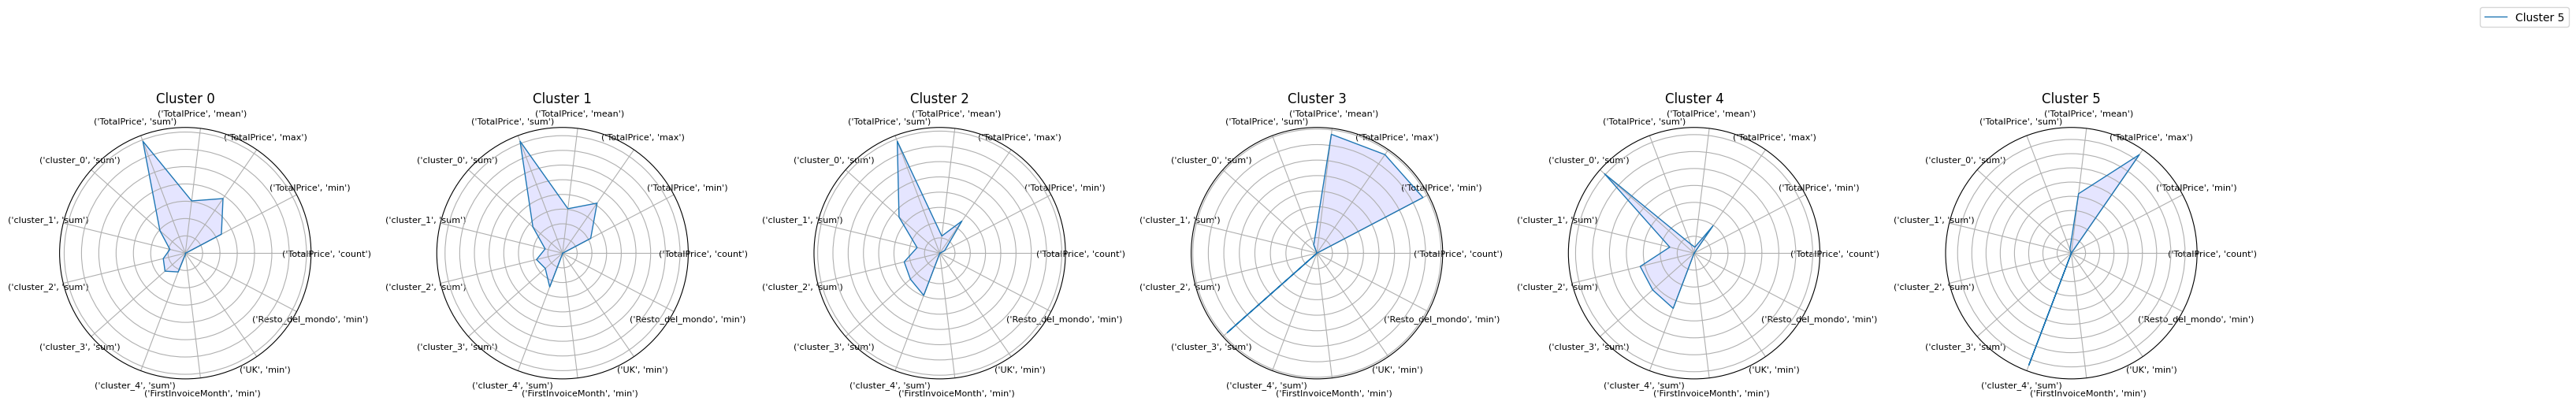

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carica i dati
df = selected_data

# Verifica se ci sono abbastanza cluster nel DataFrame
num_clusters_available = len(df['Cluster'].unique())
num_subplots = min(8, num_clusters_available)  # Numero massimo di subplots da creare

# Seleziona le prime 13 variabili dalla tabella escludendo "CustomerID" e "Cluster"
top_13_variables = df.columns[1:-1][:13]

# Ora puoi utilizzare questa lista di variabili per selezionare solo quelle dalla tua tabella
selected_data = df[['CustomerID'] + list(top_13_variables) + ['Cluster']]

# Crea il radar chart per ogni cluster
fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=(35, 10), subplot_kw=dict(polar=True))
fig.subplots_adjust(wspace=0.5)  # Aumenta lo spazio tra i subplots (regola questo valore per ottenere lo spazio desiderato)

for i, ax in enumerate(axes.flatten()):
    # Se ci sono meno di 8 cluster disponibili, interrompi il loop
    if i >= num_clusters_available:
        break

    # Numero di variabili nel radar chart
    num_vars = 13  # Utilizzeremo le prime 13 variabili

    # Definisci le etichette delle variabili
    labels = list(selected_data.columns[1:-1][:13])  # Utilizza i nomi delle colonne selezionate come etichette

    # Individua l'angolo di ogni asse/categoria
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Plotta il radar chart per il cluster corrente
    cluster_data = selected_data[selected_data['Cluster'] == i].iloc[:, 1:-1].mean().values.tolist()

    # Aggiungi zeri per completare il vettore cluster_data se ha meno di 13 elementi
    cluster_data += [0] * (num_vars - len(cluster_data))

    ax.plot(angles, cluster_data, linewidth=1, linestyle='solid', label=f'Cluster {i}')

    # Riempimento dell'area
    ax.fill(angles, cluster_data, 'b', alpha=0.1)

    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(labels, fontsize=8)  # Riduci la dimensione del font per le etichette dell'asse x

    ax.set_title(f'Cluster {i}')  # Aggiungi il titolo al subplot

# Aggiungi la legenda una sola volta al di fuori del loop
plt.legend(loc='upper right', bbox_to_anchor=(2.5, 1.5), fontsize=10)

plt.show()










E' possibile individuare dei pattern tuttavia aspettiamo di terminare l'analisi su di un campione maggiormente rappresentativo

**Provo ad implementare una logistic regression** per individuare il cluster di appartenenza considerando Meanpurchase amount e le 4 categorie di acquisto come le mie x e il cluster come la mia y in quanto l'obiettivo del mio modello è classificare i clienti dopo il loro primo acquisto.

I valori estratti tramite questa analisi mi indicheranno la bontà dello sforzo di clusterizzazione effettuato in precedenza e mi diranno in quale misura è possibile classificare un cliente sulla base degli acquisti effettuati durante la sua prima visita allo store.

In [ ]:
customer_stats_reset_with_clusters.head(10)

,CustomerID,"(CustomerID, )","(TotalPrice, count)","(TotalPrice, min)","(TotalPrice, max)","(TotalPrice, mean)","(TotalPrice, sum)","(cluster_0, sum)","(cluster_1, sum)","(cluster_2, sum)","(cluster_3, sum)","(cluster_4, sum)","(FirstInvoiceMonth, min)","(UK, min)","(Resto_del_mondo, min)","(RelationshipDuration, )",Cluster
0,12346,12346,1,77183.60,77183.60,77183.600000,5734.889,0.00,0.00,0.00,77183.60,0.00,1,1,0,1,3
1,12347,12347,7,224.82,1294.32,615.714286,4310.000,1890.83,545.52,400.25,1019.60,453.80,12,0,1,365,1
2,12348,12348,4,187.44,652.80,359.310000,1437.240,0.00,683.24,0.00,649.60,104.40,12,0,1,282,1
3,12349,12349,1,1457.55,1457.55,1457.550000,1457.550,384.14,88.80,449.45,266.72,268.44,11,0,1,1,1
4,12350,12350,1,294.40,294.40,294.400000,294.400,17.70,39.10,0.00,147.60,90.00,2,0,1,1,1
5,12352,12352,7,104.35,296.50,197.962857,1385.740,481.30,31.00,399.40,332.80,141.24,2,0,1,260,1
6,12353,12353,1,89.00,89.00,89.000000,89.000,17.70,0.00,59.70,11.60,0.00,5,0,1,1,1
7,12354,12354,1,1079.40,1079.40,1079.400000,1079.400,280.50,161.38,252.00,84.60,300.92,4,0,1,1,1
8,12355,12355,1,459.40,459.40,459.400000,459.400,169.20,0.00,45.40,244.80,0.00,5,0,1,1,1
9,12356,12356,3,58.35,1947.62,829.143333,2487.430,476.30,403.27,742.83,701.87,163.16,1,0,1,302,1


In [ ]:
customer_stats_reset_with_clusters.reset_index(drop=True, inplace=True)

print(customer_stats_reset_with_clusters)


     CustomerID (CustomerID, )  (TotalPrice, count)  (TotalPrice, min)  \
0         12346          12346                    1           77183.60   
1         12347          12347                    7             224.82   
2         12348          12348                    4             187.44   
3         12349          12349                    1            1457.55   
4         12350          12350                    1             294.40   
...         ...            ...                  ...                ...   
4330      18280          18280                    1             180.60   
4331      18281          18281                    1              80.82   
4332      18282          18282                    2              77.84   
4333      18283          18283                   16               1.95   
4334      18287          18287                    3              70.68   

      (TotalPrice, max)  (TotalPrice, mean)  (TotalPrice, sum)  \
0              77183.60        77183.600000  

In [ ]:
# Inizializza le colonne con un valore specifico
df = customer_stats_reset_with_clusters
df['cluster_0_percent'] = 0
df['cluster_1_percent'] = 0
df['cluster_2_percent'] = 0
df['cluster_3_percent'] = 0
df['cluster_4_percent'] = 0

# Sostituisci i valori NaN con 0 nel caso in cui TotalPrice sia 0
df.fillna(0, inplace=True)

# Visualizza il DataFrame con le nuove colonne
print(df)


     CustomerID (CustomerID, )  (TotalPrice, count)  (TotalPrice, min)  \
0         12346          12346                    1           77183.60   
1         12347          12347                    7             224.82   
2         12348          12348                    4             187.44   
3         12349          12349                    1            1457.55   
4         12350          12350                    1             294.40   
...         ...            ...                  ...                ...   
4330      18280          18280                    1             180.60   
4331      18281          18281                    1              80.82   
4332      18282          18282                    2              77.84   
4333      18283          18283                   16               1.95   
4334      18287          18287                    3              70.68   

      (TotalPrice, max)  (TotalPrice, mean)  (TotalPrice, sum)  \
0              77183.60        77183.600000  

In [ ]:
customer_stats_reset_with_clusters = df

# Rinomina le colonne in maniera comprensibile
df.rename(columns={'CustomerID': 'CustomerID',
                   ('CustomerID', ''): 'CustomerID_Count',
                   ('TotalPrice', 'count'): 'TotalPrice_Count',
                   ('TotalPrice', 'min'): 'TotalPrice_Min',
                   ('TotalPrice', 'max'): 'TotalPrice_Max',
                   ('TotalPrice', 'mean'): 'TotalPrice_Mean',
                   ('TotalPrice', 'sum'): 'TotalPrice_Sum',
                   ('cluster_0', 'sum'): 'Cluster_0_Sum',
                   ('cluster_1', 'sum'): 'Cluster_1_Sum',
                   ('cluster_2', 'sum'): 'Cluster_2_Sum',
                   ('cluster_3', 'sum'): 'Cluster_3_Sum',
                   ('cluster_4', 'sum'): 'Cluster_4_Sum',
                   ('FirstInvoiceMonth', 'min'): 'Firstinvoice_min',
                   ('UK', 'min'): 'UK_min',
                   ('Resto_del_mondo', 'min'): 'Resto_del_mondo',

                   'Cluster': 'Cluster'}, inplace=True)
print(customer_stats_reset_with_clusters)

     CustomerID CustomerID_Count  TotalPrice_Count  TotalPrice_Min  \
0         12346            12346                 1        77183.60   
1         12347            12347                 7          224.82   
2         12348            12348                 4          187.44   
3         12349            12349                 1         1457.55   
4         12350            12350                 1          294.40   
...         ...              ...               ...             ...   
4330      18280            18280                 1          180.60   
4331      18281            18281                 1           80.82   
4332      18282            18282                 2           77.84   
4333      18283            18283                16            1.95   
4334      18287            18287                 3           70.68   

      TotalPrice_Max  TotalPrice_Mean  TotalPrice_Sum  Cluster_0_Sum  \
0           77183.60     77183.600000        5734.889           0.00   
1            12

In [ ]:
df = customer_stats_reset_with_clusters

# Calcola i valori delle colonne cluster_x_percent
df['cluster_0_percent'] = df['Cluster_0_Sum'] / df['TotalPrice_Sum']
df['cluster_1_percent'] = df['Cluster_1_Sum'] / df['TotalPrice_Sum']
df['cluster_2_percent'] = df['Cluster_2_Sum'] / df['TotalPrice_Sum']
df['cluster_3_percent'] = df['Cluster_3_Sum'] / df['TotalPrice_Sum']
df['cluster_4_percent'] = df['Cluster_4_Sum'] / df['TotalPrice_Sum']

# Sostituisci i valori NaN con 0 nel caso in cui TotalPrice sia 0
df.fillna(0, inplace=True)


# Visualizza il DataFrame con le nuove colonne
print(df)

     CustomerID CustomerID_Count  TotalPrice_Count  TotalPrice_Min  \
0         12346            12346                 1        77183.60   
1         12347            12347                 7          224.82   
2         12348            12348                 4          187.44   
3         12349            12349                 1         1457.55   
4         12350            12350                 1          294.40   
...         ...              ...               ...             ...   
4330      18280            18280                 1          180.60   
4331      18281            18281                 1           80.82   
4332      18282            18282                 2           77.84   
4333      18283            18283                16            1.95   
4334      18287            18287                 3           70.68   

      TotalPrice_Max  TotalPrice_Mean  TotalPrice_Sum  Cluster_0_Sum  \
0           77183.60     77183.600000        5734.889           0.00   
1            12

In [ ]:
customer_stats_reset_with_clusters.columns

Index([                'CustomerID',           'CustomerID_Count',
                 'TotalPrice_Count',             'TotalPrice_Min',
                   'TotalPrice_Max',            'TotalPrice_Mean',
                   'TotalPrice_Sum',              'Cluster_0_Sum',
                    'Cluster_1_Sum',              'Cluster_2_Sum',
                    'Cluster_3_Sum',              'Cluster_4_Sum',
                 'Firstinvoice_min',                     'UK_min',
                  'Resto_del_mondo', ('RelationshipDuration', ''),
                          'Cluster',          'cluster_0_percent',
                'cluster_1_percent',          'cluster_2_percent',
                'cluster_3_percent',          'cluster_4_percent'],
      dtype='object')

Logistic regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Carica il dataset
df = customer_stats_reset_with_clusters

# Estrai le colonne X e y
X = df[['TotalPrice_Mean', 'cluster_0_percent', 'cluster_1_percent',
        'cluster_2_percent', 'cluster_3_percent', 'cluster_4_percent', 'Firstinvoice_min', 'Resto_del_mondo', 'UK_min'  ]]
y = df['Cluster']

# Dividi il dataset in set di addestramento e set di test (80% per addestramento, 20% per test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizza le caratteristiche
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crea e addestra il modello di logistic regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Valuta il modello
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)  # Evita divisione per zero

print("Accuracy:", accuracy)
print("Classification Report:\n", report)




Accuracy: 0.8465974625144176
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       612
           1       1.00      1.00      1.00        97
           2       0.89      0.16      0.27       155
           4       1.00      1.00      1.00         3

    accuracy                           0.85       867
   macro avg       0.93      0.79      0.79       867
weighted avg       0.86      0.85      0.80       867



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


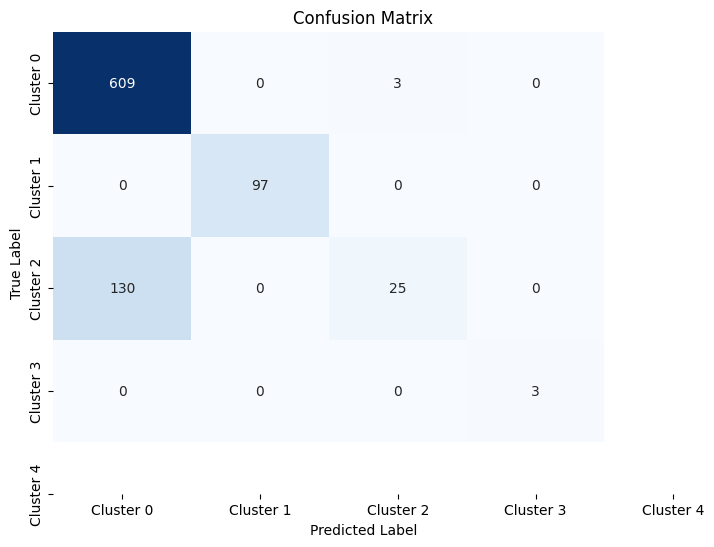

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizza la matrice di confusione utilizzando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
            yticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


La precisione del modello è del 88.81%, il che significa che il 88.81% delle previsioni fatte dal modello sono corrette.

Tuttavia, ci sono alcuni problemi nel rapporto di classificazione:

Per le classi 1 e 2, la precisione e il recall sono entrambi 0. Questo potrebbe essere dovuto al fatto che nessun esempio nel set di test appartiene a queste classi, quindi il modello non ha previsto alcun esempio per queste classi.
La precisione e il recall per la classe 0 sono entrambi piuttosto bassi. Questo suggerisce che il modello ha avuto difficoltà a identificare correttamente i casi positivi per questa classe.
La precisione, il recall e l'f1-score per la classe 5 sono più bassi rispetto alle altre classi. Anche se la precisione è ragionevolmente buona, il recall e l'f1-score indicano che il modello ha avuto difficoltà a recuperare tutti i veri positivi per questa classe.

Provo ad implementare un algoritmo di **SVC Support Vector Machine (SVM)** è un algoritmo di apprendimento supervisionato utilizzato per la classificazione e la regressione.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


# Carica il dataset
df = customer_stats_reset_with_clusters

# Estrai le colonne X e y
X = df[['TotalPrice_Mean', 'cluster_0_percent', 'cluster_1_percent',
        'cluster_2_percent', 'cluster_3_percent', 'cluster_4_percent', 'Firstinvoice_min', 'Resto_del_mondo', 'UK_min'  ]]
y = df['Cluster']

# Dividi il dataset in set di addestramento e set di test (80% per addestramento, 20% per test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea e addestra il modello SVC
model = SVC()
model.fit(X_train, y_train)

# Valuta il modello
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.7081891580161477
Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83       612
           1       0.50      0.01      0.02        97
           2       0.20      0.01      0.01       155
           4       0.00      0.00      0.00         3

    accuracy                           0.71       867
   macro avg       0.35      0.25      0.22       867
weighted avg       0.59      0.71      0.59       867



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


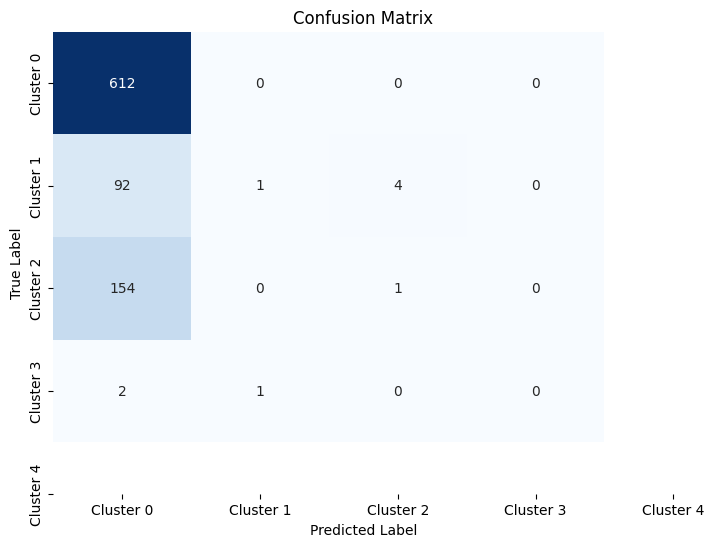

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizza la matrice di confusione utilizzando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
            yticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


L'accuratezza del modello SVM è del 89.71%,

Implemento un algoritmo di Random Forest Classifier Random Forest è un algoritmo di apprendimento supervisionato utilizzato per la classificazione e la regressione. Si basa su un insieme di alberi decisionali, noti come "forest", che vengono addestrati su sottoinsiemi casuali dei dati di addestramento e fanno previsioni combinando le previsioni di ciascun albero.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definisci le variabili X e y
X = df[['TotalPrice_Mean', 'cluster_0_percent', 'cluster_1_percent',
        'cluster_2_percent', 'cluster_3_percent', 'cluster_4_percent', 'Firstinvoice_min', 'Resto_del_mondo', 'UK_min'  ]]
y = df['Cluster']

# Dividi il dataset in set di addestramento e test (80% per addestramento, 20% per test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea e addestra il modello Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Valuta il modello
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", report_rf)



Random Forest Accuracy: 0.8662053056516724
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       612
           1       1.00      1.00      1.00        97
           2       0.71      0.43      0.53       155
           4       1.00      1.00      1.00         3

    accuracy                           0.87       867
   macro avg       0.89      0.85      0.86       867
weighted avg       0.85      0.87      0.85       867



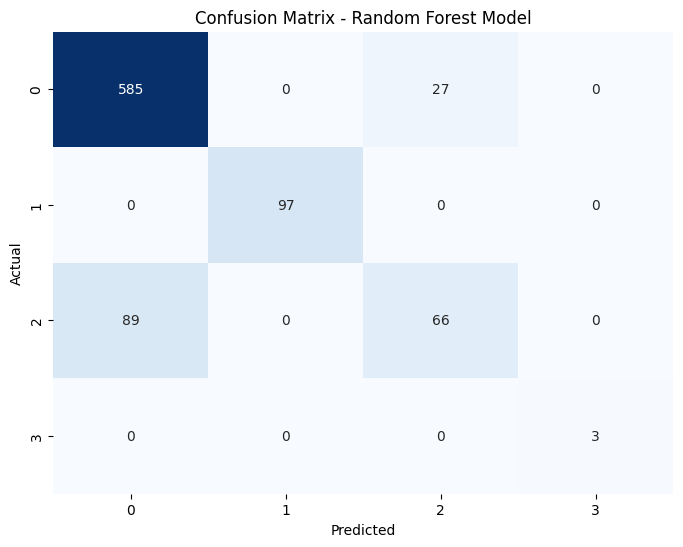

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Calcola la confusion matrix per il modello Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizza la confusion matrix per il modello Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Model')
plt.show()


Accuratezza Random forest 90%

DECISION TREE - Implemento ora un modello di decision tree

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Carica il dataset
df = customer_stats_reset_with_clusters

# Estrai le colonne X e y
# Estrai le colonne X e y
X = df[['TotalPrice_Mean', 'cluster_0_percent', 'cluster_1_percent',
        'cluster_2_percent', 'cluster_3_percent', 'cluster_4_percent', 'Firstinvoice_min', 'Resto_del_mondo', 'UK_min'  ]]
y = df['Cluster']


# Dividi il dataset in set di addestramento e set di test (80% per addestramento, 20% per test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea e addestra il modello Decision Tree
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Valuta il modello
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.8212226066897347
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       612
           1       1.00      1.00      1.00        97
           2       0.50      0.40      0.44       155
           4       1.00      1.00      1.00         3
           5       0.00      0.00      0.00         0

    accuracy                           0.82       867
   macro avg       0.67      0.66      0.66       867
weighted avg       0.81      0.82      0.81       867



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


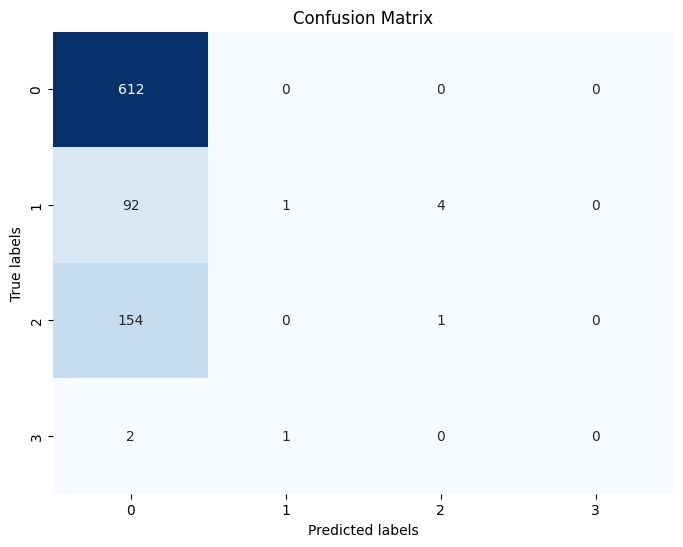

In [ ]:

# Visualizza la confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


CONCLUSIONI

I risultati e le conclusioni suggeriscono che il modello creato sembra efficace nel compito di clusterizzazione dei prodotti e dei clienti. Tuttavia, i risultati della riprova con il modello random forest sulla seconda clusterizzazione indicano che è possibile migliorare ulteriormente la capacità di raggruppamento dei clienti, utilizzando elementi come l'importo della fattura, il paniere dei beni acquistati, il mese di acquisto e il paese.

È evidente che il dataset potrebbe beneficiare di una maggiore ricchezza di informazioni socio-demografiche sui clienti, che potrebbero migliorare l'efficacia della clusterizzazione. Inoltre, confrontare i dati tra diversi anni potrebbe essere utile per classificare i clienti in modo più accurato.

Con un dataset più ampio, sarebbe possibile sviluppare metriche aggiuntive e raffinare ulteriormente la clusterizzazione dei clienti. È importante notare che il numero di clienti per cluster nella seconda clusterizzazione risulta sbilanciato, quindi è necessario migliorare questo aspetto per ottenere cluster più bilanciati e migliorare la capacità predittiva complessiva del modello.

Infine, oltre agli algoritmi K-means e K-medoids, potrebbe essere vantaggioso testare altri algoritmi di clusterizzazione per valutare le prestazioni e l'efficacia complessiva del modello.

CONCLUSIONI

I risultati e le conclusioni suggeriscono che il modello creato sembra efficace nel compito di clusterizzazione dei prodotti e dei clienti. Tuttavia, i risultati della riprova con il modello random forest sulla seconda clusterizzazione indicano che è possibile migliorare ulteriormente la capacità di raggruppamento dei clienti, utilizzando elementi come l'importo della fattura, il paniere dei beni acquistati, il mese di acquisto e il paese.

È evidente che il dataset potrebbe beneficiare di una maggiore ricchezza di informazioni socio-demografiche sui clienti, che potrebbero migliorare l'efficacia della clusterizzazione. Inoltre, confrontare i dati tra diversi anni potrebbe essere utile per classificare i clienti in modo più accurato.

Con un dataset più ampio, sarebbe possibile sviluppare metriche aggiuntive e raffinare ulteriormente la clusterizzazione dei clienti. È importante notare che il numero di clienti per cluster nella seconda clusterizzazione risulta sbilanciato, quindi è necessario migliorare questo aspetto per ottenere cluster più bilanciati e migliorare la capacità predittiva complessiva del modello.

Infine, oltre agli algoritmi K-means e K-medoids, potrebbe essere vantaggioso testare altri algoritmi di clusterizzazione per valutare le prestazioni e l'efficacia complessiva del modello.

CONCLUSIONI

I risultati e le conclusioni suggeriscono che il modello creato sembra efficace nel compito di clusterizzazione dei prodotti e dei clienti. Tuttavia, i risultati della riprova con il modello random forest sulla seconda clusterizzazione indicano che è possibile migliorare ulteriormente la capacità di raggruppamento dei clienti, utilizzando elementi come l'importo della fattura, il paniere dei beni acquistati, il mese di acquisto e il paese.

È evidente che il dataset potrebbe beneficiare di una maggiore ricchezza di informazioni socio-demografiche sui clienti, che potrebbero migliorare l'efficacia della clusterizzazione. Inoltre, confrontare i dati tra diversi anni potrebbe essere utile per classificare i clienti in modo più accurato.

Con un dataset più ampio, sarebbe possibile sviluppare metriche aggiuntive e raffinare ulteriormente la clusterizzazione dei clienti. È importante notare che il numero di clienti per cluster nella seconda clusterizzazione risulta sbilanciato, quindi è necessario migliorare questo aspetto per ottenere cluster più bilanciati e migliorare la capacità predittiva complessiva del modello.

Infine, oltre agli algoritmi K-means e K-medoids, potrebbe essere vantaggioso testare altri algoritmi di clusterizzazione per valutare le prestazioni e l'efficacia complessiva del modello.